Checking that the rotation angle files will work.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import scipy.interpolate as interp
import os
from matplotlib.path import Path

%matplotlib inline

# Functions

In [2]:
def rotate_velocity(xv, yv, theta):
    """Rotate velocity vector (xv, yv) to new coordinate system.
    theta is the counterclockise angle measured from the x-axis of new coordinate system 
    and the x-axis of the (xv, yv) coordinate system
    If theta represents the angle between x grid lines and East than the result 
    is zonal (U) and meridional (V) velocities
    returns U,V - velocity along x and y axis in new coordinate system"""
    theta_rad = np.radians(theta)
    U = xv*np.cos(theta_rad) - yv*np.sin(theta_rad)
    V = xv*np.sin(theta_rad) + yv*np.cos(theta_rad)
    return U, V

In [3]:
def load_rotated_velocities(ufile, vfile, anglefile,
                            varu='vozocrtx', varv='vomecrty', 
                            varlon='nav_lon',varlat='nav_lat'):
    """Assuming u/v are already unstaggered"""
    f = nc.Dataset(ufile)
    xv = f.variables[varu][:]
    f.close()
    
    f = nc.Dataset(vfile)
    yv = f.variables[varv][:]
    f.close()
    
    f = nc.Dataset(anglefile)
    theta = f.variables['alpha'][:]
    lon = f.variables[varlon][:]
    lat = f.variables[varlat][:]
    f.close()
    
    u, v = rotate_velocity(xv,yv,theta)
    
    return u,v,lon, lat

# SalishSea

In [4]:
date='20170401'
basedir = '/data/hdd/salishsea/model_Agrid/'
ufile=os.path.join(basedir, date,'SalishSea_1h_{}_{}_grid_U_Agrid.nc'.format(date,date))
vfile=os.path.join(basedir, date,'SalishSea_1h_{}_{}_grid_V_Agrid.nc'.format(date,date))
anglefile = '/data/hdd/salishsea/grid/grid_angle_201702.nc'

u,v,lon,lat = load_rotated_velocities(ufile,vfile, anglefile)

f = nc.Dataset('/data/hdd/salishsea/grid/bathymetry_201702.nc')
bathy = f.variables['Bathymetry'][:]
f.close()

f = nc.Dataset('/data/hdd/salishsea/grid/mesh_mask201702.nc')
tmask = f.variables['tmask'][:]
f.close()

u = np.ma.array(u, mask=np.ones(u.shape) - tmask)
v = np.ma.array(v, mask=np.ones(v.shape) - tmask)

### Plotting
* Skip basemap for now -> issues with vector rotation with an irregular grid (ie need to interpolate...)

(48, 49)

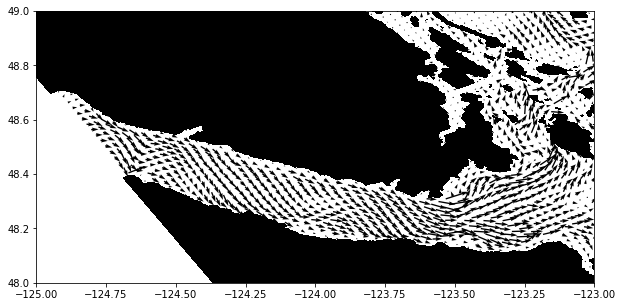

In [5]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
st=5
t=0
d=0
ax.quiver(lon[::st, ::st], lat[::st, ::st], u[t,d,::st,::st,], v[t,d,::st,::st],scale=50)
ax.contourf(lon, lat, bathy.data, [-0.1,0.1], colors='k')
ax.set_xlim([-125,-123])
ax.set_ylim([48,49])

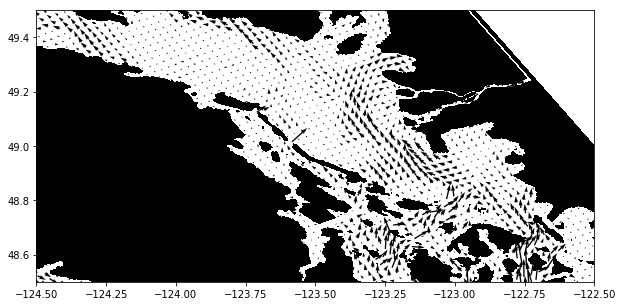

In [6]:
ax.set_xlim([-124.5,-122.5])
ax.set_ylim([48.5,49.5])
fig

Expecting flood tide base on currents. Check ssh at near Point Atkinson

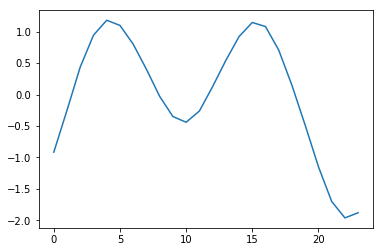

In [7]:
tfile = os.path.join(basedir, date,'SalishSea_1h_{}_{}_grid_T.nc'.format(date,date) )
f = nc.Dataset(tfile)
ssh = f.variables['sossheig'][:]
j,i=480,330
plt.plot(ssh[:,j,i])

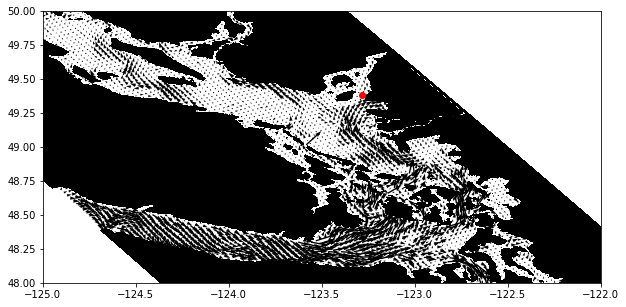

In [8]:
ax.set_xlim([-125,-122])
ax.set_ylim([48,50])
ax.plot(lon[j,i],lat[j,i],'ro')
fig

Water level rising at Point Atkinson -> flood tide

# Plotting with basemap
* Interpolate to regular grid first, then basemap
* Interpolation is more sophisticated in Ocean Navigator but this gives an indication that basemap won't work unless you have a pretty regular grid.
* This is arbitrary, but masked velocity bigger than 1.5 m/s for to avoid very large vectors after interpolation. 

In [9]:
def interp_fields(up,vp,lons,lats, nx=500,ny=500):
    x1, x2, y1, y2 = lons.min(), lons.max(), lats.min(), lats.max()
    xgrid, ygrid = np.meshgrid(np.linspace(x1,x2,nx), np.linspace(y1,y2,ny)) 
    points = np.array([lons.flatten(), lats.flatten()]).T
    uinterp = interp.griddata(points, up.flatten(), (xgrid, ygrid))
    vinterp = interp.griddata(points, vp.flatten(), (xgrid, ygrid))
    # interp mask
    umask = interp.griddata(points, up.mask.flatten(), (xgrid, ygrid), method='nearest', fill_value=1)
    vmask = interp.griddata(points, vp.mask.flatten(), (xgrid, ygrid), method='nearest', fill_value=1)
    uinterp = np.ma.array(uinterp, mask=umask)
    vinterp = np.ma.array(vinterp, mask=vmask)
    return uinterp, vinterp, xgrid,ygrid

In [10]:
def interp_and_plot(ax, ui,vi,xgrid, ygrid,
                    lon1=-127, lon2=-122, lat1=47, lat2=50, lat_ts=49,
                    res='h', scale=3, st=10):
    # plotting
    ui = np.ma.masked_where(np.abs(ui)>1.5, ui)
    vi = np.ma.masked_where(np.abs(vi)>1.5,vi)
    
    m = Basemap(projection='merc',llcrnrlat=lat1,urcrnrlat=lat2,
            llcrnrlon=lon1,urcrnrlon=lon2,lat_ts=lat_ts,resolution=res)
    m.drawcoastlines()
    ubm, vbm, x, y = m.rotate_vector(ui, vi, xgrid, ygrid, returnxy=True)
    q=m.quiver(x[::st,::st], y[::st,::st],ubm[::st,::st],vbm[::st,::st],scale=scale,ax=ax)
    ax.quiverkey(q, 0.3,0.1,1.5, '1.5 m/s', coordinates='axes')

In [11]:
uinterp, vinterp, xgrid,ygrid = interp_fields(u[t,d,:,:], v[t,d,:,:], lon, lat)

/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


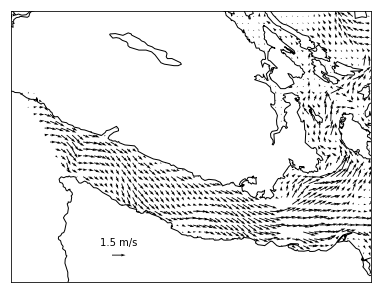

In [12]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
interp_and_plot(ax, uinterp, vinterp, xgrid, ygrid, scale=40, st=3,
               lat1=48, lon1=-125, lon2=-123, lat2=49)

# GIOPS

In [13]:
date='201704'
day='01'
basedir = '/data/hdd/giops/daily'
ufile=os.path.join(basedir, date,'giops_{}{}00_024.nc'.format(date,day))
vfile=ufile
anglefile = '/data/hdd/grids/giops/grid_angle.nc'

u,v,lon,lat = load_rotated_velocities(ufile,vfile, anglefile)

f = nc.Dataset('/data/hdd/grids/giops/mesh_mask.nc')
tmask = f.variables['tmask'][:]
f.close()

u = np.ma.array(u, mask=np.ones(u.shape) - tmask)
v = np.ma.array(v, mask=np.ones(v.shape) - tmask)


In [14]:
t,d=0,0
uinterp, vinterp, xgrid,ygrid = interp_fields(u[t,d,:,:], v[t,d,:,:], lon, lat)

/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3109: RuntimeWarning: invalid value encountered in greater_equal
  farnorth = np.abs(lats+dlat) >= 90.0


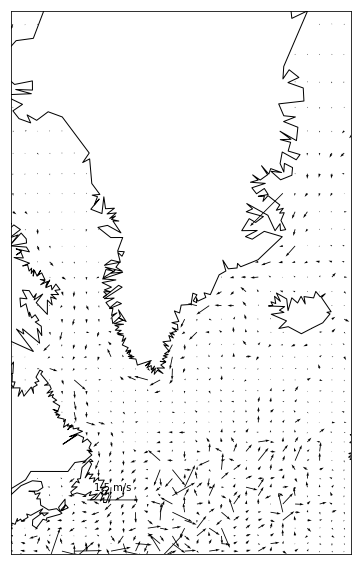

In [15]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
interp_and_plot(ax, uinterp, vinterp, xgrid, ygrid, scale=10, st=3,
               lat1=40, lon1=-70, lon2=-10, lat2=80, res='c')

In [16]:
def pcolorplot(ax,var,xgrid, ygrid):
    # plotting
    m =  Basemap(projection='npstere',boundinglat=60,lon_0=270,resolution='l', ax=ax)
    m.drawcoastlines()
    m.fillcontinents(color='coral',lake_color='aqua')
    x,y=m(xgrid,ygrid)
    mesh=m.pcolormesh(x,y,var,ax=ax,vmin=-.3,vmax=.3)
    plt.colorbar(mesh, ax=ax)
    

In [17]:
def quiver_plot_polar(ax,ui,vi,xgrid, ygrid,  scale=10, st=3):
    ui = np.ma.masked_where(np.abs(ui)>1.5, ui)
    vi = np.ma.masked_where(np.abs(vi)>1.5,vi)
    # plotting
    m =  Basemap(projection='npstere',boundinglat=60,lon_0=270,resolution='l', ax=ax)
    m.drawcoastlines()
    m.fillcontinents(color='coral',lake_color='aqua')
    ubm, vbm, x, y = m.rotate_vector(ui, vi, xgrid, ygrid, returnxy=True)
    q=m.quiver(x[::st,::st], y[::st,::st],ubm[::st,::st],vbm[::st,::st],scale=scale,ax=ax)
    ax.quiverkey(q, 0.3,0.1,1.5, '1.5 m/s', coordinates='axes')
    

/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0.5,1,u'V [m/s]')

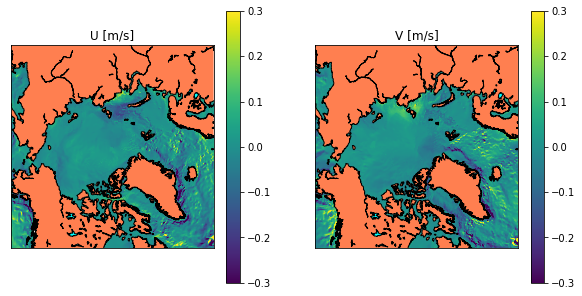

In [18]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
pcolorplot(axs[0], u[t,d,:,:], lon, lat)
axs[0].set_title('U [m/s]')
pcolorplot(axs[1], v[t,d,:,:], lon, lat)
axs[1].set_title('V [m/s]')


/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


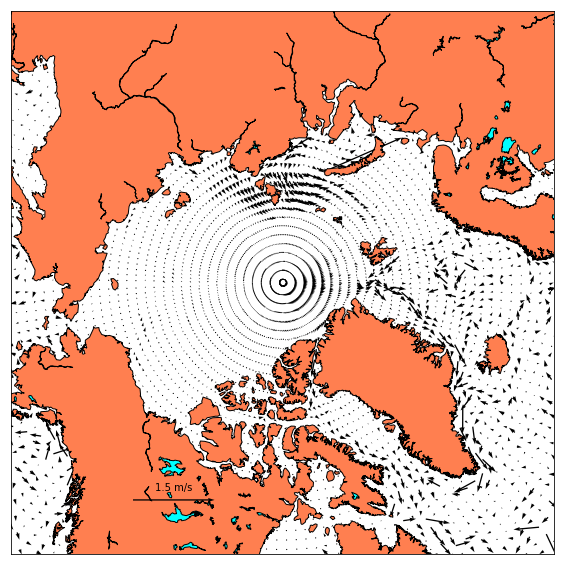

In [19]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
quiver_plot_polar(ax,uinterp,vinterp,xgrid, ygrid, scale=10, st=3)

# RIOPS

In [20]:
date='20170310'
basedir = '/data/hdd/riops/riops_daily/'
ufile=os.path.join(basedir,'{}_2D.nc'.format(date))
vfile=ufile
anglefile = '/data/hdd/grids/riops/grid_angle.nc'

u,v,lon,lat = load_rotated_velocities(ufile,vfile, anglefile, 
                                      varlon='longitude', varlat='latitude')

inds = np.where(lon>180)
lon[inds] = lon[inds] -360

In [21]:
t=0
uinterp, vinterp, xgrid,ygrid = interp_fields(u[t,:,:], v[t,:,:], lon, lat)

/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


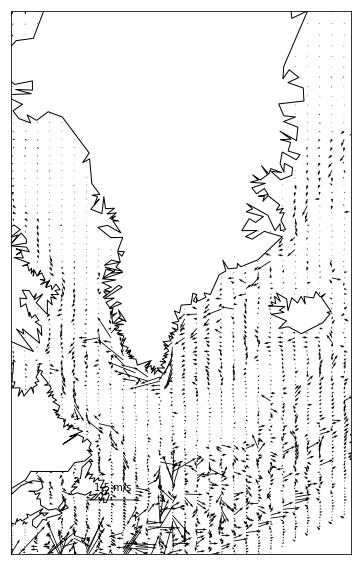

In [22]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
interp_and_plot(ax, uinterp, vinterp, xgrid, ygrid, scale=10, st=3,
               lat1=40, lon1=-70, lon2=-10, lat2=80, res='c')

Text(0.5,1,u'V [m/s]')

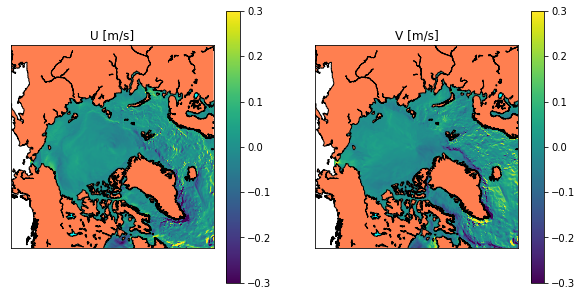

In [23]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
pcolorplot(axs[0], u[t,:,:], lon, lat)
axs[0].set_title('U [m/s]')
pcolorplot(axs[1], v[t,:,:], lon, lat)
axs[1].set_title('V [m/s]')

/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


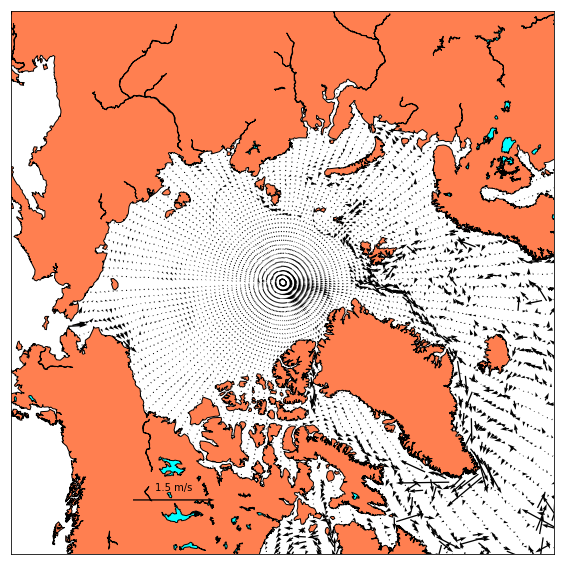

In [27]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
quiver_plot_polar(ax,uinterp,vinterp,xgrid, ygrid, scale=10, st=4)